In [46]:
# Naudotos bibliotekos

# Duomenų apdorojimas ir analizė
import pandas as pd
import numpy as np
from collections import Counter

# Vizualizacija
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Teksto apdorojimas ir duomenų skirstymas
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy

# Modelių kūrimas ir testavimas
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Modelio vertinimas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Papildomi įrankiai
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV

In [47]:
df = pd.read_csv("/content/final_final.csv", index_col=0)

In [48]:
# Išmetam 'title_url_count', nes visur 0
df = df.drop(columns=['title_url_count'])

# Kai tvarkiaus duomenis pas mane buvo nan atsirade
df.isnull().sum()
df.dropna(inplace=True)

In [49]:
df.shape

(44159, 26)

## Esybių dažnių grafikai


In [50]:
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Extract and categorize entities
def extract_entities(text):
    doc = nlp(text)
    people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return people, orgs

# Remove rows with NaN in the `processed_text` column
df = df.dropna(subset=["processed_text2"])

df[["people_ent", "organizations_ent"]] = df["processed_text2"].apply(
    lambda x: pd.Series(extract_entities(x))
)

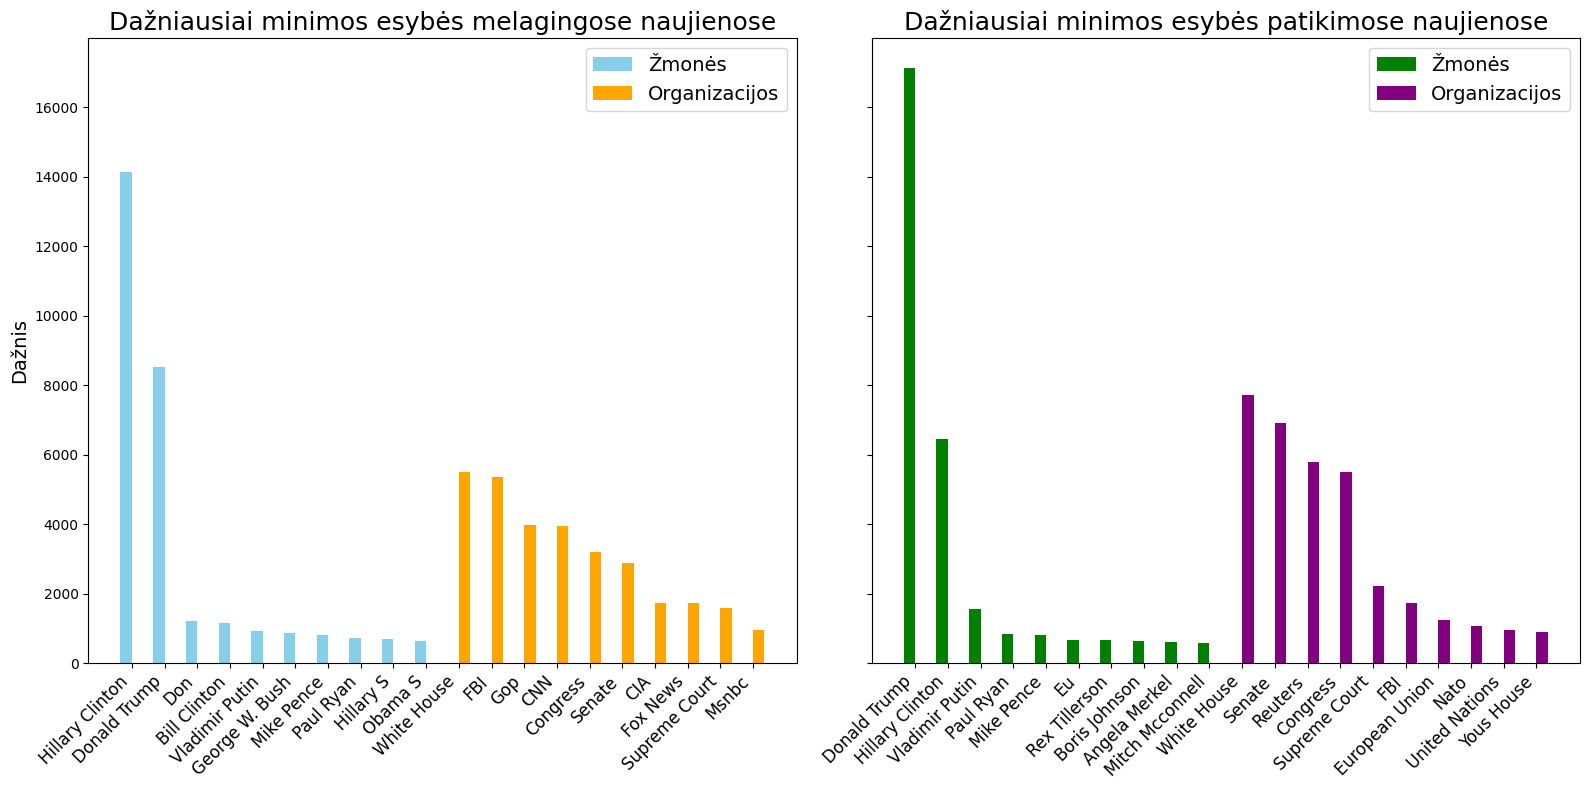

In [51]:
# Apjungiamia tu paciu zmoniu vardus
entity_mapping = {
    "trump": "Donald Trump",
    "donald trump": "Donald Trump",
    "donald trumps": "Donald Trump",
    "donald trump s": "Donald Trump",
    "trumps": "Donald Trump",
    "clinton": "Hillary Clinton",
    "hillary clinton": "Hillary Clinton",
    "obama": "Barack Obama",
    "barack obama": "Barack Obama",
    "hillary": "Hillary Clinton",
    "comey": "James Comey",
    "putin": "Vladimir Putin",
    "vladimir putin": "Vladimir Putin",
    "ryan": "Paul Ryan",
    "paul": "Paul Ryan",
    "cruz": "Ted Cruz",
    "sanders": "Bernie Sanders",
    "pelosi": "Nancy Pelosi",
    "johnson": "Boris Johnson",
    "bush": "George W. Bush",
    "mike": "Mike Pence",
    "the white house": "White House",
    "cnn": "CNN",
    "fbi": "FBI",
    "cia": "CIA",
    "senate": "Senate",
    "congress": "Congress",
    "reuters": "Reuters",
    "the european union": "European Union"
}

# Normalize entities
df["people_ent"] = df["people_ent"].apply(
    lambda people: [entity_mapping.get(person.lower(), person.title()) for person in people]
)
df["organizations_ent"] = df["organizations_ent"].apply(
    lambda orgs: [entity_mapping.get(org.lower(), org.title()) for org in orgs]
)

# Helper function to get top entities
def get_top_entities(label, entity_column, n=10):
    entities = df.loc[df["label"] == label, entity_column].explode()
    return Counter(entities).most_common(n)

# Get top entities for fake and true news
top_fake_people = get_top_entities(0, "people_ent")
top_true_people = get_top_entities(1, "people_ent")
top_fake_orgs = get_top_entities(0, "organizations_ent")
top_true_orgs = get_top_entities(1, "organizations_ent")

# Create DataFrames for plotting
def create_plot_data(counter_list):
    if not counter_list:
        return pd.DataFrame(columns=["Entity", "Count"])
    return pd.DataFrame(counter_list, columns=["Entity", "Count"]).set_index("Entity")

fake_people_df = create_plot_data(top_fake_people)
true_people_df = create_plot_data(top_true_people)
fake_orgs_df = create_plot_data(top_fake_orgs)
true_orgs_df = create_plot_data(top_true_orgs)

# Combine people and organization data
def combine_dataframes(people_df, orgs_df):
    combined_df = pd.concat(
        [
            people_df.rename(columns={"Count": "People"}),
            orgs_df.rename(columns={"Count": "Organizations"}),
        ],
        axis=1,
    ).fillna(0)
    return combined_df

fake_combined_df = combine_dataframes(fake_people_df, fake_orgs_df)
true_combined_df = combine_dataframes(true_people_df, true_orgs_df)

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot Fake News
x = np.arange(len(fake_combined_df.index))
width = 0.35
axes[0].bar(x - width / 2, fake_combined_df["People"], width, label="Žmonės", color="skyblue")
axes[0].bar(x + width / 2, fake_combined_df["Organizations"], width, label="Organizacijos", color="orange")
axes[0].set_title("Dažniausiai minimos esybės melagingose naujienose", fontsize=18)
axes[0].set_ylabel("Dažnis", fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(fake_combined_df.index, rotation=45, ha="right", fontsize=12)
axes[0].legend(fontsize=14)

# Plot True News
x = np.arange(len(true_combined_df.index))
axes[1].bar(x - width / 2, true_combined_df["People"], width, label="Žmonės", color="green")
axes[1].bar(x + width / 2, true_combined_df["Organizations"], width, label="Organizacijos", color="purple")
axes[1].set_title("Dažniausiai minimos esybės patikimose naujienose", fontsize=18)
axes[1].set_xticks(x)
axes[1].set_xticklabels(true_combined_df.index, rotation=45, ha="right", fontsize=12)
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()


## Koreliacijų matrica

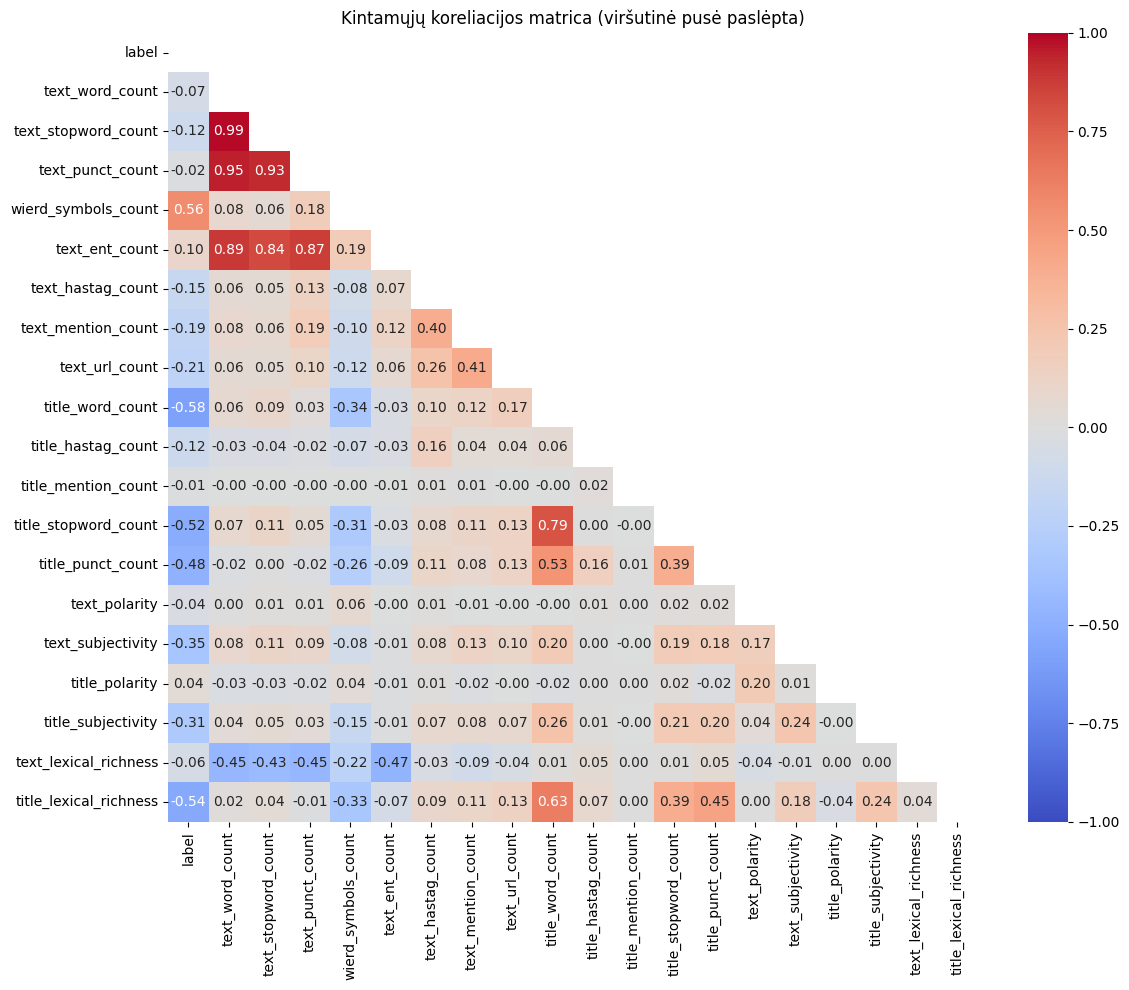

In [52]:
# Pasirenkame tik skaitinius stulpelius
numeric_columns = df.select_dtypes(include=['number']).columns

# Apskaičiuojame koreliacijos matricą
correlation_matrix = df[numeric_columns].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Kintamųjų koreliacijos matrica (viršutinė pusė paslėpta)")
plt.tight_layout()
plt.show()


## WorldCloud Grafikai

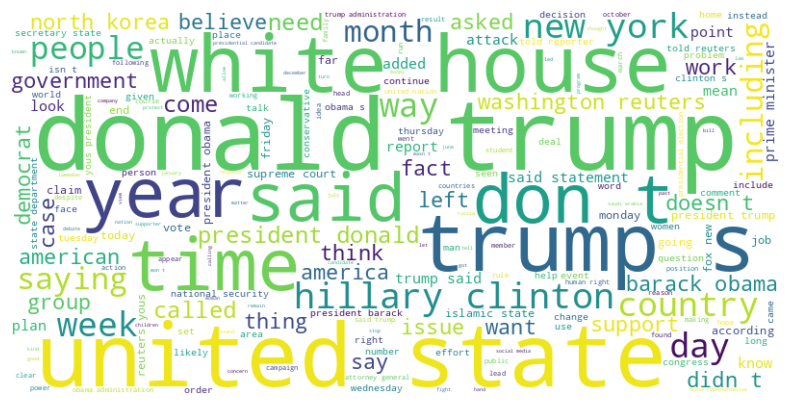

In [53]:
# Bendras
text = " ".join(df['processed_text2'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

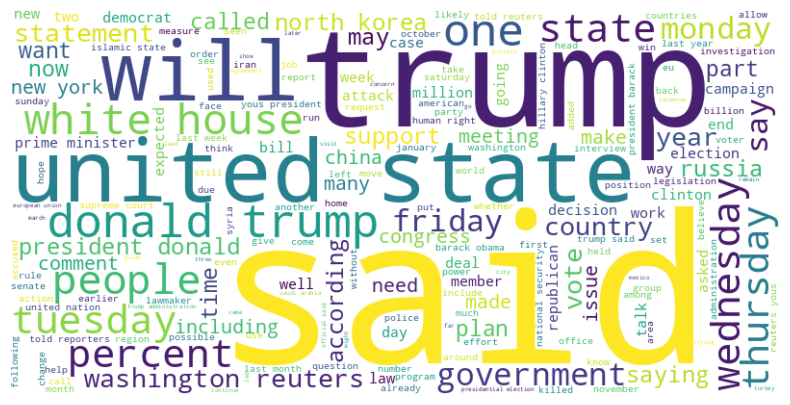

In [54]:
# Real
consolidated_true = ' '.join(
    word for word in df['processed_text'][df['label'] == 1].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(consolidated_true)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

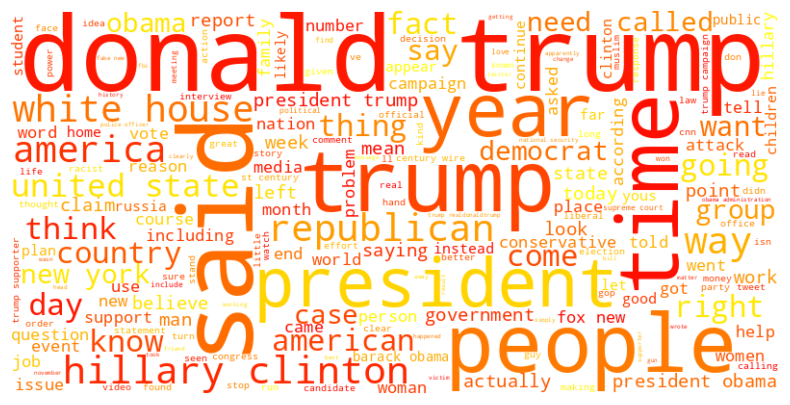

In [55]:
import re
# Fake
consolidated_fake = ' '.join(
    word for word in df['processed_text2'][df['label'] == 0].astype(str)
)

# Remove possessive "'s" and standalone single letters
cleaned_text = re.sub(r"\b\w's\b", "", consolidated_fake)  # Remove possessive forms
cleaned_text = re.sub(r"\b\w\b", "", cleaned_text)    # Remove single characters
cleaned_text = re.sub(r"\s+", " ", cleaned_text)      # Normalize spaces

# Generate a reddish word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='autumn'
).generate(cleaned_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Funkcija piesti painiavos matricas

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrices(conf_matrices, titles, colors, display_labels=["MELAGINGOS", "PATIKIMOS"],
                            figure_size=(60, 20), font_size_title=45, font_size_axis=40,
                            font_size_values=60, tick_label_size=35, tick_label_pad=20, label_pad=30):
    """
    Piešia painiavos matricas vienodame formate.

    Args:
        conf_matrices (list of ndarray): Painiavos matricos kiekvienam modeliui.
        titles (list of str): Modelių pavadinimai.
        colors (list of str): Spalvų schemos kiekvienai matricai.
        display_labels (list of str): Klasių pavadinimai (default: ["MELAGINGOS", "PATIKIMOS"]).
        figure_size (tuple): Grafiko dydis (default: (60, 20)).
        font_size_title (int): Pavadinimų šrifto dydis (default: 45).
        font_size_axis (int): Ašių pavadinimų šrifto dydis (default: 40).
        font_size_values (int): Reikšmių šrifto dydis (default: 60).
        tick_label_size (int): Ašių žymėjimų šrifto dydis (default: 35).
        tick_label_pad (int): Atstumas tarp žymėjimo ir ašies (default: 20).
        label_pad (int): Atstumas tarp ašies ir pavadinimo (default: 30).
    """
    num_matrices = len(conf_matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=figure_size)
    fig.subplots_adjust(wspace=0.5)

    for ax, cm, cmap, title in zip(axes, conf_matrices, colors, titles):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
        disp.plot(cmap=cmap, ax=ax, values_format='d', colorbar=False)
        for text in disp.text_.ravel():
            text.set_fontsize(font_size_values)
        ax.set_title(title, fontsize=font_size_title)
        ax.set_xlabel("PRISKIRTA KLASĖ", fontsize=font_size_axis, labelpad=label_pad)
        ax.set_ylabel("TIKROJI KLASĖ", fontsize=font_size_axis, labelpad=label_pad)
        ax.tick_params(axis='x', labelsize=tick_label_size, pad=tick_label_pad)
        ax.tick_params(axis='y', labelsize=tick_label_size, pad=tick_label_pad)
        ax.grid(False)

    plt.tight_layout()
    plt.show()


## Modelis su visais kiekybiniais features

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Pašaliname ne skaitinius stulpelius bei label
feature_columns = df.drop(columns=['label', 'title', 'text', 'processed_text',
                                    'people_ents', 'org_ents', 'people_ent',
                                    'organizations_ent', 'processed_text2'])

X_feat = feature_columns.iloc[:, 1:]
y = df['label']

# Mokymo ir testavimo duomenų padalinimas
X_feat_train, X_feat_test, y_feat_train, y_feat_test = train_test_split(X_feat, y, test_size=0.3, random_state=42)

# Modeliai ir jų pavadinimai
models = {
    "LOGISTINĖ REGRESIJA": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=10000))
    ]),
    "ATRAMINIŲ VEKTORIŲ KLASIFIKATORIUS": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='linear', max_iter=10000))
    ]),
    "ARTIMIAUSIŲ KAIMYNŲ KLASIFIKATORIUS": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ])
}

# Painiavos matricos saugykla
conf_matrices = []
titles = []
colors = ["Reds", "Blues", "Greens"]  # Spalvų schemos

# Modelių mokymas ir prognozių generavimas
for name, pipeline in models.items():
    pipeline.fit(X_feat_train, y_feat_train)
    y_pred = pipeline.predict(X_feat_test)

    # Tikslumo spausdinimas
    print(f"{name} Tikslumas:", accuracy_score(y_feat_test, y_pred))
    print(classification_report(y_feat_test, y_pred))

    # Išsaugome painiavos matricą
    conf_matrices.append(confusion_matrix(y_feat_test, y_pred))
    titles.append(name)


LOGISTINĖ REGRESIJA Tikslumas: 0.9290458937198067
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      6874
         1.0       0.92      0.93      0.93      6374

    accuracy                           0.93     13248
   macro avg       0.93      0.93      0.93     13248
weighted avg       0.93      0.93      0.93     13248



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


ATRAMINIŲ VEKTORIŲ KLASIFIKATORIUS Tikslumas: 0.9159118357487923
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      6874
         1.0       0.88      0.96      0.92      6374

    accuracy                           0.92     13248
   macro avg       0.92      0.92      0.92     13248
weighted avg       0.92      0.92      0.92     13248

ARTIMIAUSIŲ KAIMYNŲ KLASIFIKATORIUS Tikslumas: 0.923762077294686
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93      6874
         1.0       0.91      0.94      0.92      6374

    accuracy                           0.92     13248
   macro avg       0.92      0.92      0.92     13248
weighted avg       0.92      0.92      0.92     13248



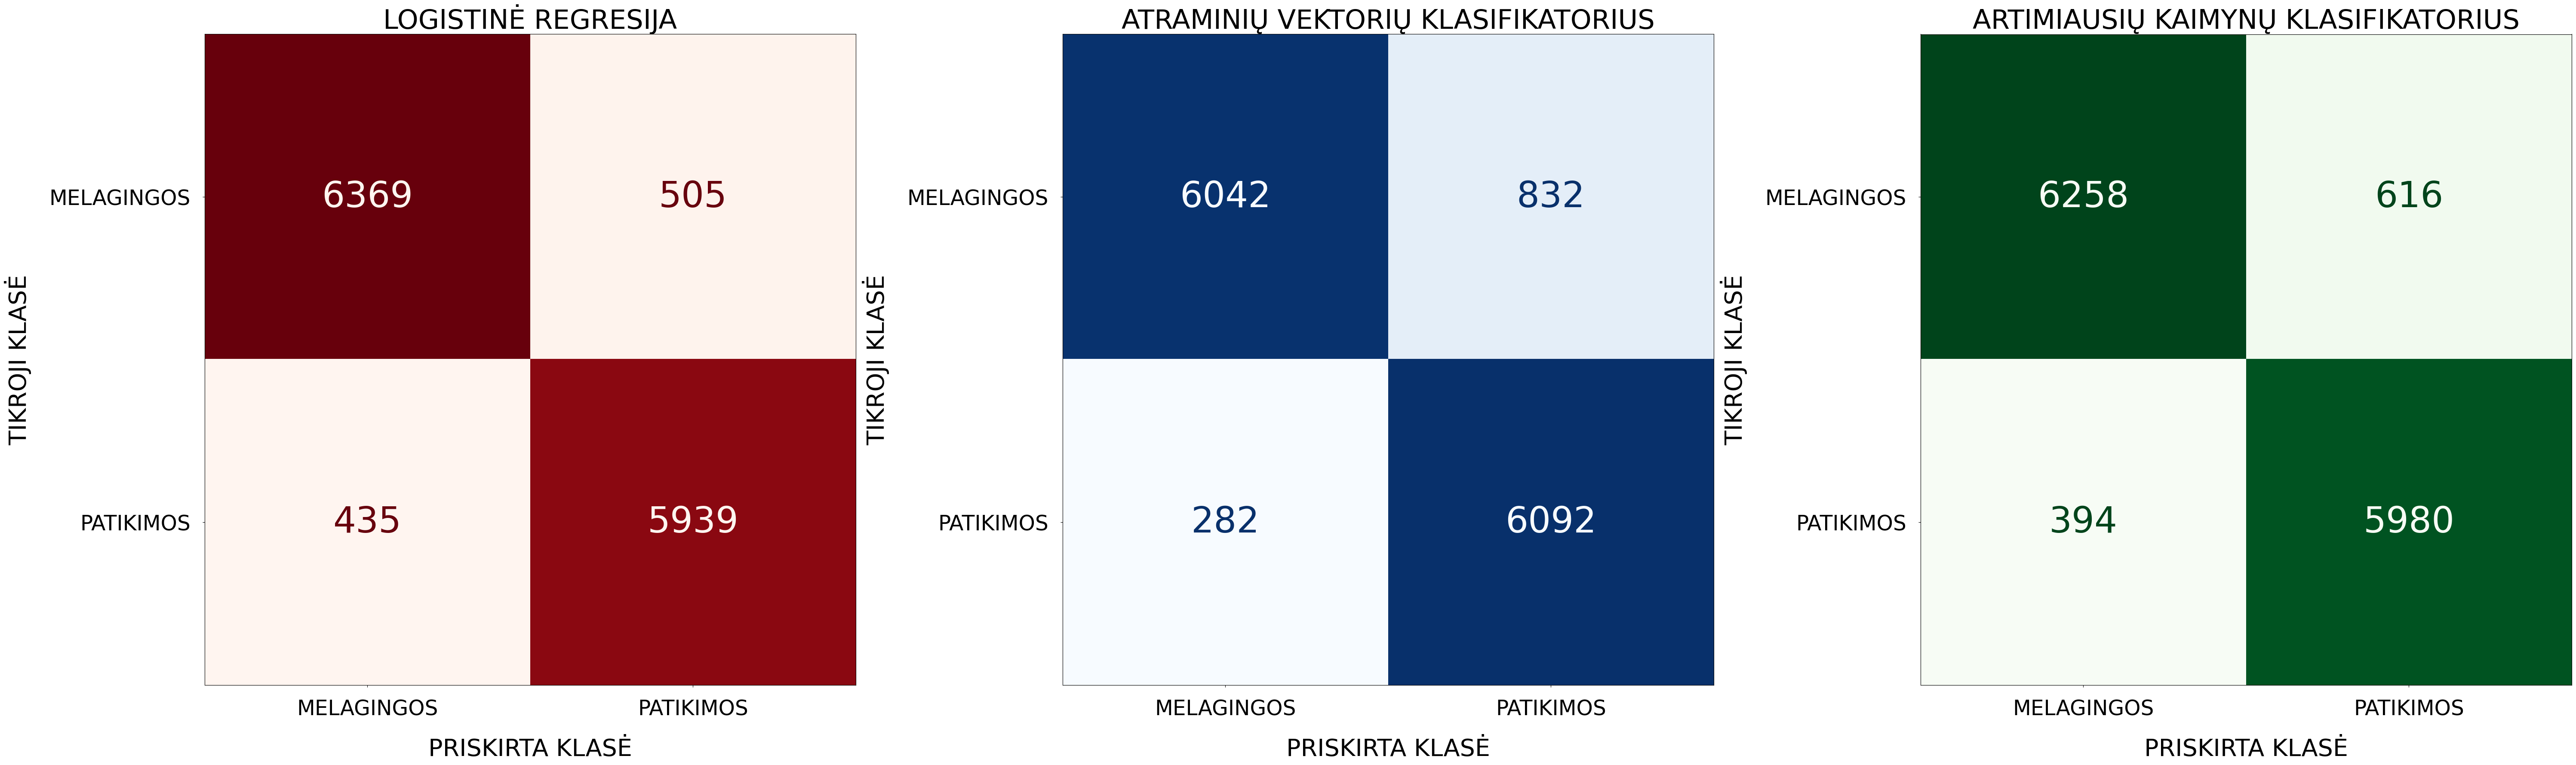

In [58]:
# Piešiame painiavos matricas
plot_confusion_matrices(
    conf_matrices=conf_matrices,
    titles=titles,
    colors=colors
)

## Parinkti features pagal elimination with Cross-Validation

In [59]:
# Pašaliname ne skaitinius stulpelius bei label
X_imp = df.drop(['label', 'title', 'text', 'processed_text', 'people_ents', 'org_ents', 'people_ent', 'organizations_ent', 'processed_text2'], axis=1)
y_imp = df["label"]

# Standartizuojame požymius
scaler = StandardScaler()
X_imp_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X_imp.columns)

# Padalijame duomenis į mokymo ir testavimo aibę
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp_scaled, y_imp, test_size=0.3, random_state=42)

# Logistinės regresijos modelis, pagal kurį ieškosim svarbiausių požymių
model = LogisticRegression(max_iter=10000, random_state=42)

# RFECV požymių atranka
feature_selector = RFECV(estimator=model, cv=5, scoring='accuracy')
fit = feature_selector.fit(X_imp_train, y_imp_train)


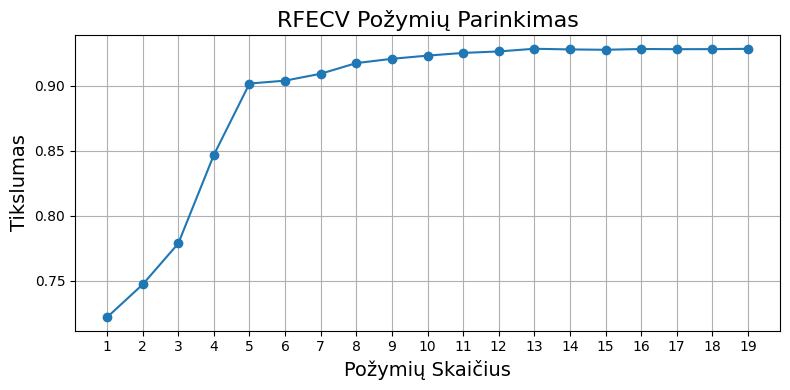

In [60]:
# Gauti optimalų požymių skaičių
optimal_feature_count = feature_selector.n_features_

# Pasirinkti optimalūs požymiai
selected_features = X_imp_train.columns[feature_selector.support_]

# RFECV rezultato grafikas
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(feature_selector.cv_results_['mean_test_score']) + 1),
    feature_selector.cv_results_['mean_test_score'],
    marker="o"
)

# Pažymime požymių skaičiaus reikšmes ant ašies
plt.xticks(
    ticks=range(1, len(feature_selector.cv_results_['mean_test_score']) + 1),
    labels=range(1, len(feature_selector.cv_results_['mean_test_score']) + 1)
)
plt.title(f"RFECV Požymių Parinkimas", fontsize=16)
plt.xlabel("Požymių Skaičius", fontsize=14)
plt.ylabel("Tikslumas", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Spausdiname rezultatus
# print(f"Optimalus požymių skaičius: {optimal_feature_count}")
# print(f"Pasirinkti požymiai: {list(selected_features)}")


In [61]:
# Pirmieji 10 pasirinkti požymiai
selected_features_10 = list(selected_features[:10])
print(f"Pirmieji 10 pasirinkti požymiai: {selected_features_10}")

Pirmieji 10 pasirinkti požymiai: ['text_word_count', 'text_stopword_count', 'wierd_symbols_count', 'text_ent_count', 'text_hastag_count', 'text_mention_count', 'text_url_count', 'title_word_count', 'title_hastag_count', 'title_stopword_count']


## Naudojant 10 naudingiausiu features ir teksta

In [62]:
# Pasirenkame 10 požymių ir priskiriame tikslinę etiketę
X_text_feat = df[selected_features_10]
y_text_feat = df['label']

# Vektorizuojame `processed_text2` naudodami TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
processed_text2_tfidf = tfidf.fit_transform(df['processed_text2']).toarray()

# Užtikriname, kad indeksai sutaptų ir prireikus juos atstatome
X_text_feat = pd.DataFrame(X_text_feat).reset_index(drop=True)
processed_text2_tfidf_df = pd.DataFrame(processed_text2_tfidf).reset_index(drop=True)

# Sujungiame skaitinius požymius su vektorizuotais `processed_text2`
X_text_feat_combined = pd.concat([X_text_feat, processed_text2_tfidf_df], axis=1)

# Paverčiame stulpelių pavadinimus į string tipo, kad išvengtume klaidų
X_text_feat_combined.columns = X_text_feat_combined.columns.astype(str)

# Padalijame duomenis į mokymo ir testavimo aibę
X_train_text_feat, X_test_text_feat, y_train_text_feat, y_test_text_feat = train_test_split(
    X_text_feat_combined, y_text_feat, test_size=0.3, random_state=42
)

In [63]:
# Modeliai ir jų pavadinimai
models = {
    "LOGISTINĖ REGRESIJA": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=10000))
    ]),
    "ATRAMINIŲ VEKTORIŲ KLASIFIKATORIUS": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='linear', max_iter=10000, random_state=42))
    ]),
    "ARTIMIAUSIŲ KAIMYNŲ KLASIFIKATORIUS": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    "NAIVE BAYES KLASIFIKATORIUS": Pipeline([
        ('classifier', MultinomialNB())
    ])
}

# Painiavos matricos saugykla
conf_matrices = []
titles = []
colors = ["Reds", "Blues", "Greens", "Purples"]  # Spalvų schemos

# Modelių mokymas ir prognozių generavimas
for name, pipeline in models.items():
    pipeline.fit(X_train_text_feat, y_train_text_feat)
    y_pred = pipeline.predict(X_test_text_feat)

    # Tikslumo spausdinimas
    print(f"{name} Tikslumas:", accuracy_score(y_test_text_feat, y_pred))
    print(classification_report(y_test_text_feat, y_pred))

    # Išsaugome painiavos matricą
    conf_matrices.append(confusion_matrix(y_test_text_feat, y_pred))
    titles.append(name)


LOGISTINĖ REGRESIJA Tikslumas: 0.996225845410628
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6874
         1.0       1.00      1.00      1.00      6374

    accuracy                           1.00     13248
   macro avg       1.00      1.00      1.00     13248
weighted avg       1.00      1.00      1.00     13248



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


ATRAMINIŲ VEKTORIŲ KLASIFIKATORIUS Tikslumas: 0.9935839371980676
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6874
         1.0       0.99      0.99      0.99      6374

    accuracy                           0.99     13248
   macro avg       0.99      0.99      0.99     13248
weighted avg       0.99      0.99      0.99     13248

ARTIMIAUSIŲ KAIMYNŲ KLASIFIKATORIUS Tikslumas: 0.6719504830917874
              precision    recall  f1-score   support

         0.0       0.62      0.97      0.75      6874
         1.0       0.93      0.35      0.50      6374

    accuracy                           0.67     13248
   macro avg       0.77      0.66      0.63     13248
weighted avg       0.77      0.67      0.63     13248

NAIVE BAYES KLASIFIKATORIUS Tikslumas: 0.9239885265700483
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      6874
         1.0       0.89      0.96      0.92     

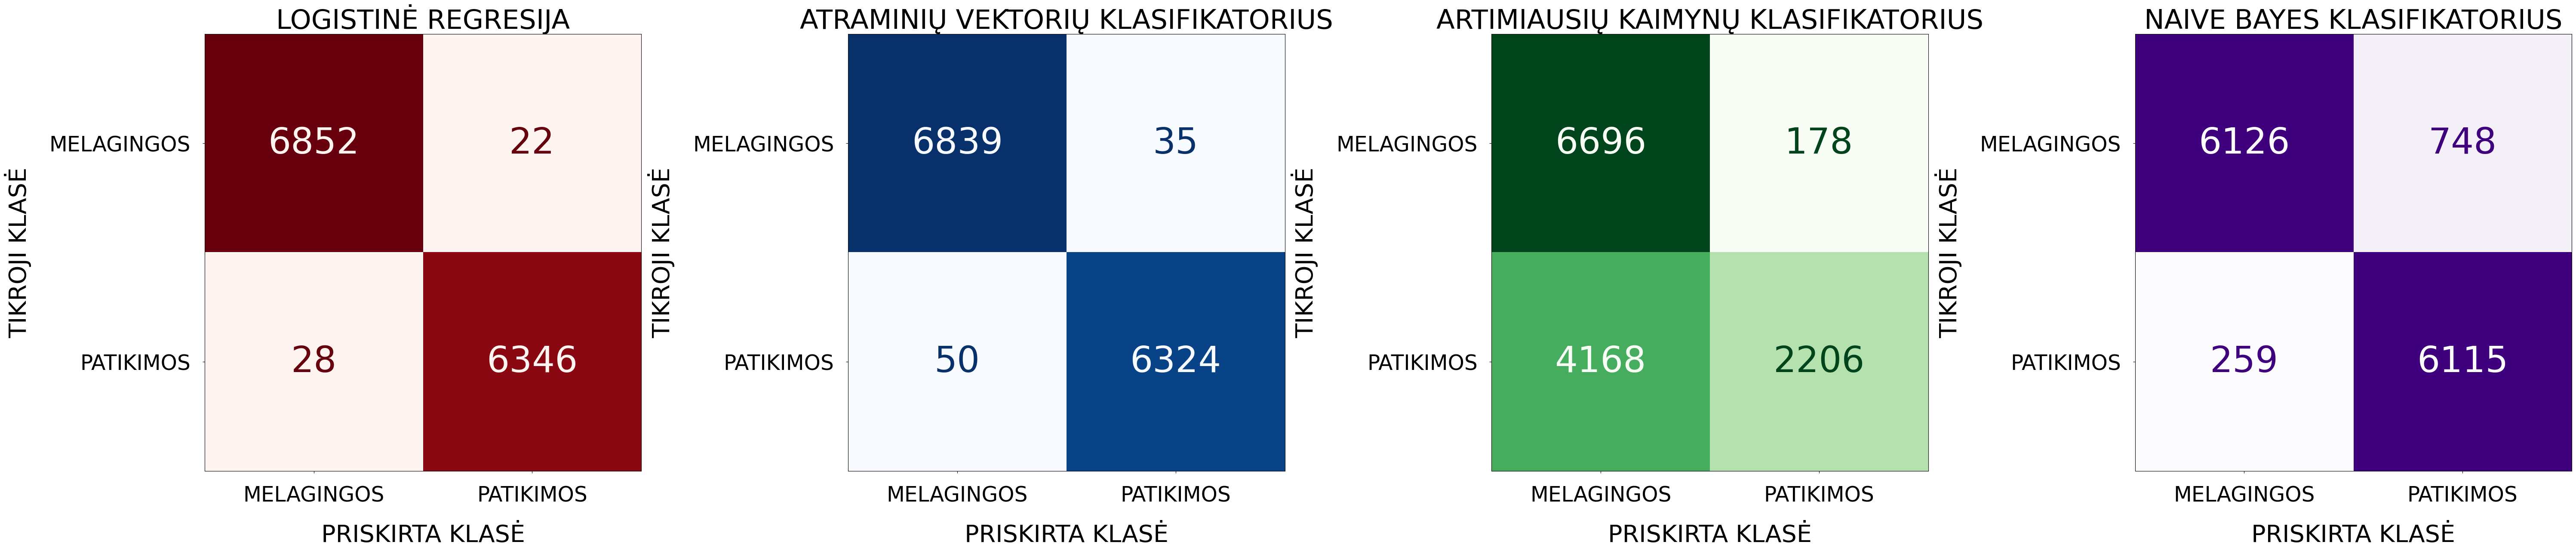

In [64]:
# Piešiame painiavos matricas
plot_confusion_matrices(
    conf_matrices=conf_matrices,
    titles=titles,
    colors=colors
)

## Naudojant tik TF-IDF processed text

In [65]:
# Nustatome tekstą ir etiketes
X_text = df['processed_text2']
y = df['label']

# Padalijame tekstinius duomenis į mokymo ir testavimo aibes
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42)

# Konvertuojame tekstą į skaitinius požymius naudodami TF-IDF
vectorizer = TfidfVectorizer()
X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)


# Modeliai ir jų pavadinimai
models = {
    "LOGISTINĖ REGRESIJA": Pipeline([
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    "ATRAMINIŲ VEKTORIŲ KLASIFIKATORIUS": Pipeline([
        ('classifier', SVC(kernel='linear', random_state=42))
    ]),
    "ARTIMIAUSIŲ KAIMYNŲ KLASIFIKATORIUS": Pipeline([
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    "NAIVE BAYES KLASIFIKATORIUS": Pipeline([
        ('classifier', MultinomialNB())
    ])
}

# Painiavos matricos saugykla
conf_matrices = []
titles = []
colors = ["Reds", "Blues", "Greens", "Purples"]  # Spalvų schemos

# Modelių mokymas ir prognozių generavimas
for name, pipeline in models.items():
    pipeline.fit(X_text_train_tfidf, y_train)
    y_pred = pipeline.predict(X_text_test_tfidf)

    # Tikslumo spausdinimas
    print(f"{name} Tikslumas:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Išsaugome painiavos matricą
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    titles.append(name)


LOGISTINĖ REGRESIJA Tikslumas: 0.9866394927536232
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6874
         1.0       0.98      0.99      0.99      6374

    accuracy                           0.99     13248
   macro avg       0.99      0.99      0.99     13248
weighted avg       0.99      0.99      0.99     13248

ATRAMINIŲ VEKTORIŲ KLASIFIKATORIUS Tikslumas: 0.9947161835748792
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      6874
         1.0       0.99      1.00      0.99      6374

    accuracy                           0.99     13248
   macro avg       0.99      0.99      0.99     13248
weighted avg       0.99      0.99      0.99     13248

ARTIMIAUSIŲ KAIMYNŲ KLASIFIKATORIUS Tikslumas: 0.8691878019323671
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.86      6874
         1.0       0.81      0.95      0.87      6374

 

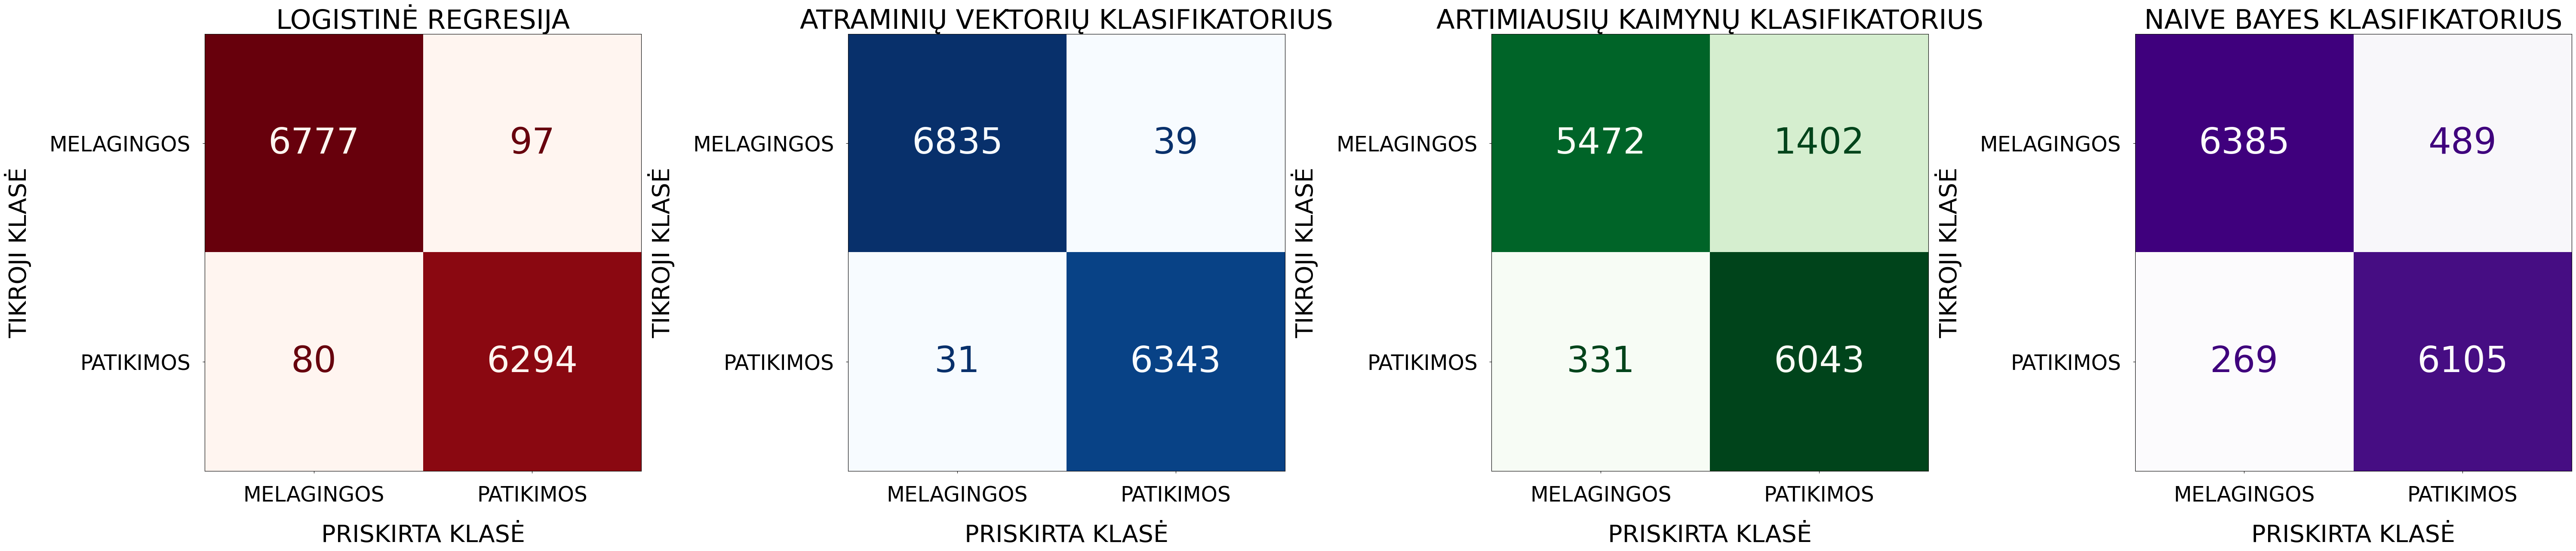

In [66]:
# Piešiame painiavos matricas
plot_confusion_matrices(
    conf_matrices=conf_matrices,
    titles=titles,
    colors=colors
)


## Naudojant Bag of Words processed text

In [69]:
# Duomenų padalijimas į mokymo ir testavimo aibes (tekstui)
X_text_train, X_text_test, y_train, y_test = train_test_split(
    df['processed_text2'], df['label'], test_size=0.3, random_state=42
)

# Modeliai ir jų pavadinimai
pipelines = {
    "LOGISTINĖ REGRESIJA": Pipeline([
        ('vectorizer', CountVectorizer(max_features=1000)),
        ('classifier', LogisticRegression(max_iter=10000))
    ]),
        "ATRAMINIŲ VEKTORIŲ KLASIFIKATORIUS": Pipeline([
        ('vectorizer', CountVectorizer(max_features=1000)),
        ('classifier', SVC(kernel='linear', max_iter=10000))
    ]),
    "ARTIMIAUSIŲ KAIMYNŲ KLASIFIKATORIUS": Pipeline([
        ('vectorizer', CountVectorizer(max_features=1000)),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    "NAIVE BAYES KLASIFIKATORIUS": Pipeline([
        ('vectorizer', CountVectorizer(max_features=1000)),
        ('classifier', MultinomialNB())
    ])
}

# Painiavos matricos saugykla
conf_matrices = []
titles = []
colors = ["Reds", "Blues", "Greens", "Purples"]  # Spalvų schemos

# Modelių mokymas ir prognozių generavimas
for name, pipeline in pipelines.items():
    pipeline.fit(X_text_train, y_train)
    y_pred = pipeline.predict(X_text_test)

    # Tikslumo spausdinimas
    print(f"{name} Tikslumas: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

    # Išsaugome painiavos matricą
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    titles.append(name)


LOGISTINĖ REGRESIJA Tikslumas: 0.9942632850241546
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      6874
         1.0       1.00      0.99      0.99      6374

    accuracy                           0.99     13248
   macro avg       0.99      0.99      0.99     13248
weighted avg       0.99      0.99      0.99     13248



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


ATRAMINIŲ VEKTORIŲ KLASIFIKATORIUS Tikslumas: 0.9907910628019324
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6874
         1.0       0.99      0.99      0.99      6374

    accuracy                           0.99     13248
   macro avg       0.99      0.99      0.99     13248
weighted avg       0.99      0.99      0.99     13248

ARTIMIAUSIŲ KAIMYNŲ KLASIFIKATORIUS Tikslumas: 0.8843599033816425
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88      6874
         1.0       0.85      0.92      0.88      6374

    accuracy                           0.88     13248
   macro avg       0.89      0.89      0.88     13248
weighted avg       0.89      0.88      0.88     13248

NAIVE BAYES KLASIFIKATORIUS Tikslumas: 0.9458786231884058
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      6874
         1.0       0.93      0.96      0.94     

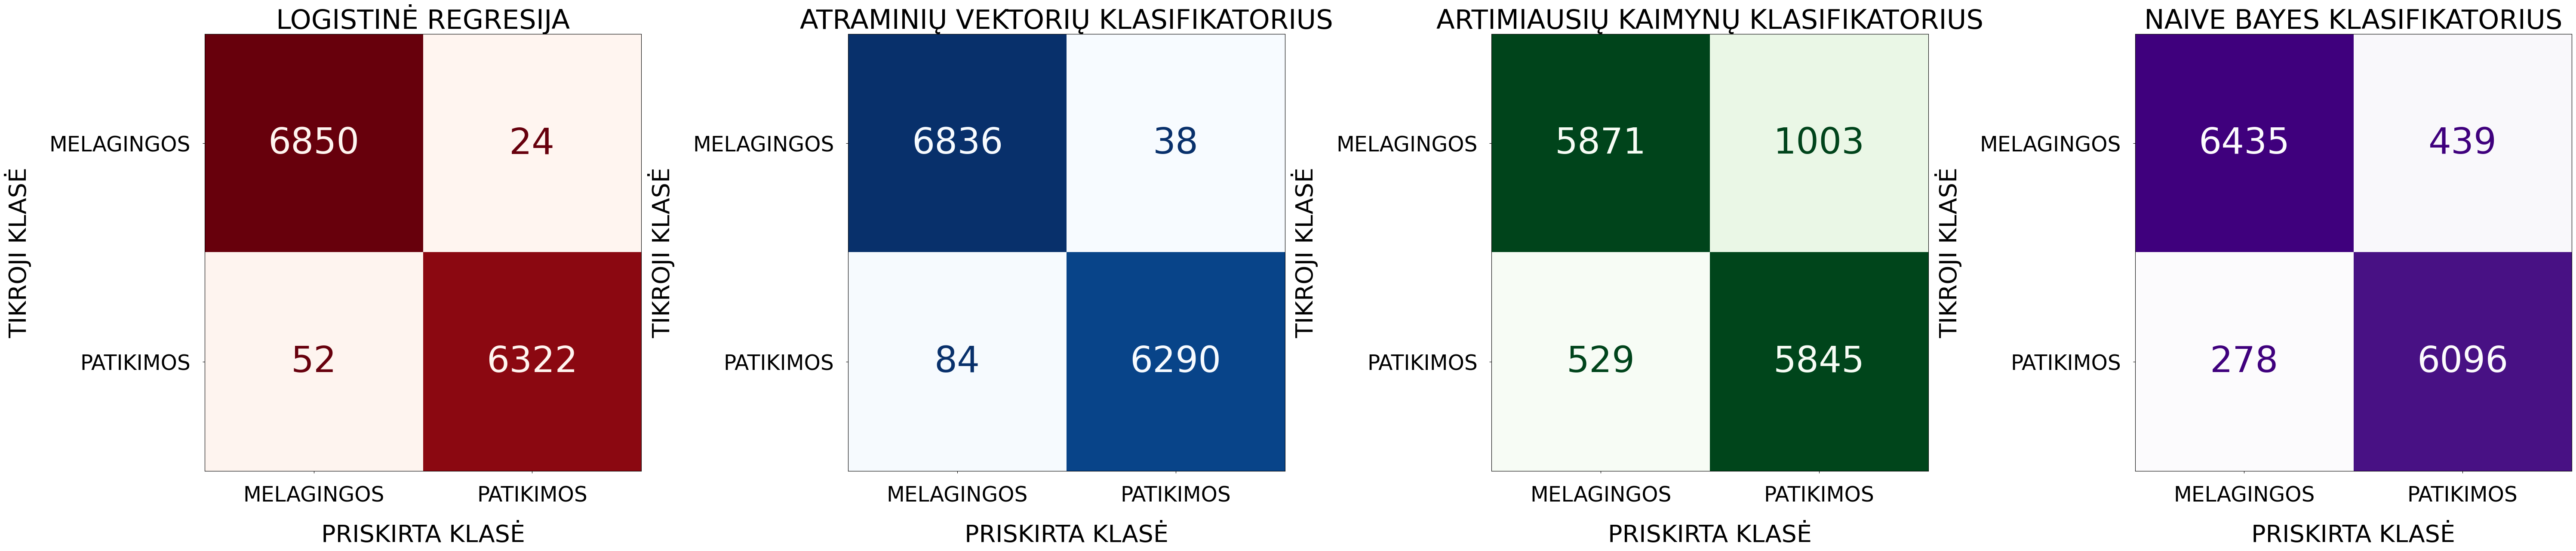

In [70]:
# Piešiame painiavos matricas
plot_confusion_matrices(
    conf_matrices=conf_matrices,
    titles=titles,
    colors=colors
)
